In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import re
from utils.custom_dataset import TextDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
dataset = pd.read_csv('dataset/IMDB_preprocessed_v2.csv')
data = dataset[['review_final', 'sentiment']].copy()
data['label'] = data['sentiment'].map({'negative': 0, 'positive': 1})

# Trim reviews

In [3]:
def trim_review(text, max_words=400):
    words = text.split()
    if len(words) <= max_words:
        return text
    if len(words) > (max_words + 50): # якщо . ! ? немає
        return " ".join(words[:max_words])
    
    trimmed = words[:max_words]
    for w in words[max_words:]:
        trimmed.append(w)
        if re.search(r'[.!?]$', w):
            break
    return " ".join(trimmed)

In [4]:
data['review_final'] = data['review_final'].apply(trim_review)

In [5]:
word_counts = data["review_final"].str.split().str.len()

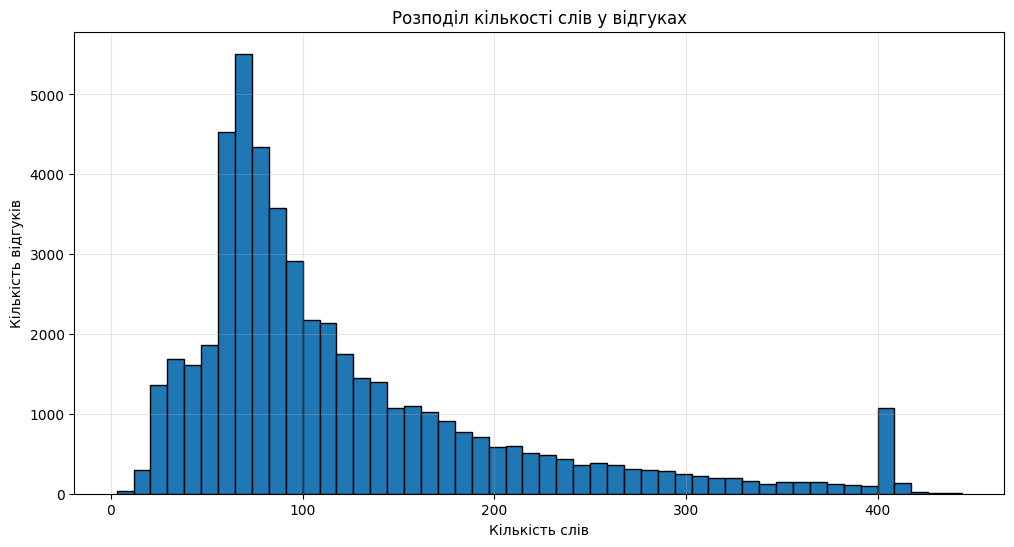

In [6]:
plt.figure(figsize=(12, 6))
plt.hist(word_counts, bins=50, edgecolor='black')
plt.title("Розподіл кількості слів у відгуках")
plt.xlabel("Кількість слів")
plt.ylabel("Кількість відгуків")
plt.grid(alpha=0.3)
plt.show()

In [7]:
views = data['review_final'].tolist()
y = data['label'].values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(views, y, test_size=0.2, random_state=42)

# Model

In [8]:
class MiniLMSentimentClassifier(nn.Module):
    def __init__(self,
        model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
        dropout_p: float = 0.2,
        max_seq_length: int = 256,
        device: str = "cuda"):
        super().__init__()

        self.device = device
        self.max_seq_length = max_seq_length

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.encoder = AutoModel.from_pretrained(model_name).to(device)

        embedding_dim = self.encoder.config.hidden_size  # 384 for MiniLM

        self.fc1 = nn.Linear(embedding_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.out = nn.Linear(64, 1) 
        self.dropout = nn.Dropout(dropout_p)

        self.init_weights()

    def init_weights(self):
        for layer in [self.fc1, self.fc2, self.out]:   # Xavier для нових Linear-шарів
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0.0)

    def mean_pooling(token_embeddings: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, texts: list[str]) -> torch.Tensor:
        # токенізація
        encoded_input = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_seq_length,
            return_tensors="pt"
        ).to(self.device)

        model_output = self.encoder(**encoded_input)

        # mean pooling з attention_mask
        token_embeddings = model_output[0]  # (batch, seq_len, hidden_size)
        sentence_embeddings = self.mean_pooling(token_embeddings, encoded_input["attention_mask"])
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

        x = self.dropout(F.relu(self.bn1(self.fc1(sentence_embeddings))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        logits = self.out(x)  # (batch, 1)

        return logits

# Train func

In [19]:
import time
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [50]:
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, num_workers=4, shuffle=True)

In [ ]:
def train_step(model, loss_fn, opt, loader):
    loss_per_batches = 0
    elapsed = 0
    start_epoch2 = time.time()
    for i, data in enumerate(loader):
        
        start_epoch = time.time()
        features, labels = data
        opt.zero_grad()

        y_pred = model(features)
        loss = loss_fn(y_pred, labels)
        loss.backward()

        opt.step()
        loss_per_batches += loss
        end_epoch = time.time()
        elapsed += (end_epoch - start_epoch)

    print("train = " + str(elapsed))
    print("train + load = " + str(time.time() - start_epoch2))
    return loss_per_batches/(i+1)

In [ ]:
def train(model, mw, loss_fn, opt, train_loader, val_loader, batch_size, 
          save_treshold=5, epochs=50, model_name='model_name'):
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs)

    for epoch in range(epochs):
        mw.print_epoch(epoch + 1)
        metrics_valid = Metrics()

        model.train()
        avg_loss = train_step(model, loss_fn, opt, train_loader, batch_size)
        model.eval()

        vloss = 0
        counter = 0
        with torch.inference_mode():
            for i, vdata in enumerate(val_loader):
                vfeatures, vlabels = vdata
                vfeatures, vlabels = vfeatures.to(device), vlabels.to(device)

                y_pred = model(vfeatures)
                bloss = loss_fn(y_pred, vlabels)
                vloss += bloss

                probs = torch.sigmoid(logits)
                y_pred = (probs > 0.5).long()
                metrics_valid.batch_step(vlabels, y_pred)
                counter = i

        avg_vloss = vloss / (counter + 1)

        scheduler.step()

        valrecall, valprecision, valf1, valacc = metrics_valid.get_metrics()
        mw.writer_step(avg_loss, avg_vloss, valrecall, valprecision, valf1, valacc)
        mw.save_model(model)
        mw.print_time()

# Test

In [21]:
loss_fn = nn.BCEWithLogitsLoss()

In [51]:
random_tensor = torch.rand(16, 1, dtype=torch.float)

In [52]:
for i, data in enumerate(tqdm(train_dataloader, desc="Training", total=len(train_dataloader))):
    features, labels = data
    loss = loss_fn(random_tensor, labels)
    print(labels)
    break

Training:   0%|                                                                               | 0/2500 [00:00<?, ?it/s]

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]])


Training:   0%|                                                                               | 0/2500 [00:10<?, ?it/s]


In [53]:
loss

tensor(0.8180)

In [24]:
random_tensor

tensor([[0.0121],
        [0.1502],
        [0.5430],
        [0.0497],
        [0.2962],
        [0.9860],
        [0.0803],
        [0.7950],
        [0.9945],
        [0.1891],
        [0.2476],
        [0.9451],
        [0.1466],
        [0.9278],
        [0.1980],
        [0.6847]])

In [42]:
input_s = torch.randn(3,)
target = torch.empty(3).random_(2)
output = loss_fn(input_s, target)

In [43]:
input_s

tensor([ 0.0909, -0.1847,  0.7278])

In [48]:
target.dtype

torch.float32

# Temp

In [ ]:
def train(model, mw, loss_fn, opt, train_loader, val_loader, batch_size, save_treshold=5, epochs=50, model_name='model_name'):

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_type, module = model.get_info()
    writer = SummaryWriter('/runs/' + model_name + '{}_{}_{}'.format(model_type, module, timestamp))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs)
    

    for epoch in range(epochs):
        start_epoch = time.time()
        metrics_valid = Metrics()
        print('EPOCH {}:'.format(epoch + 1))

        model.train()
        avg_loss = train_step(model, loss_fn, opt, train_loader, batch_size)
        model.eval()

        vloss = 0
        counter = 0
        with torch.inference_mode():
            for i, vdata in enumerate(val_loader):
                vfeatures, vlabels = vdata
                vfeatures, vlabels = vfeatures.to(device), vlabels.to(device)

                y_pred = model(vfeatures)
                bloss = loss_fn(y_pred, vlabels)
                vloss += bloss

                probs = torch.sigmoid(logits)
                y_pred = (probs > 0.5).long()
                
                metrics_valid.batch_step(vlabels, y_pred)
                counter = i

        avg_vloss = vloss / (counter + 1)

        scheduler.step()

        valrecall, valprecision, valf1, valacc = metrics_valid.get_metrics()
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        print('Accuracy valid {}'.format(valacc))
        print('Recall valid {}'.format(valrecall))
        print('Precision valid {}'.format(valprecision))
        print('Val F1->{}'.format(valf1))
        print('roc auc valid {}'.format(roc_auc))

        loss_train.append(avg_loss)
        loss_val.append(avg_vloss)
        acc_val.append(valacc)
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training': avg_loss, 'Validation': avg_vloss },
                    epoch + 1)
        writer.add_scalars('Validation Metrics',
                    { 'Validation Recall': valrecall, 'Validation Precision': valprecision, 'Validation F1': valf1
                    }, epoch + 1)
        writer.add_scalars('Validation Accuracy',
                    { 'Validation Accuracy': valacc
                    }, epoch + 1)

        if (epoch + 1) % save_treshold == 0:
            model_path = '/model_svs/' + model_name +'_{}_{}_{}_{}'.format(model_type, module, 
                                                                          timestamp, (epoch + 1))
            torch.save(model.state_dict(), model_path)
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        print("Time per epoch {}s".format(elapsed))

In [ ]:
def train(model, loss_fn, opt, train_loader, val_loader, PAD_IDX, epochs=10, save_treshold=100, model_name='model_name'):

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/' + model_name + '_{}'.format(timestamp))

    for epoch in range(epochs):
        start_epoch = time.time()
        print('EPOCH {}:'.format(epoch + 1))

        model.train()
        avg_loss, acc = train_step(model, loss_fn, opt, train_loader, PAD_IDX)
        model.eval()

        vloss = 0
        counter = 0
        r = 0
        c = 0
        avg_vloss = 0

        with torch.inference_mode():
            for i, vdata in enumerate(val_loader):
                vfeatures, vlabels = vdata
                vfeatures, vlabels = vfeatures.to(device), vlabels.to(device)

                c += vlabels.shape[0]

                src_padding_mask = (vfeatures == PAD_IDX)

                y_pred = model(vfeatures, src_padding_mask)

                soft_out = nn.functional.softmax(y_pred, dim=-1)
                out = soft_out.argmax(dim=-1)
                r += (vlabels == out).sum()

                vloss += loss_fn(y_pred.to(torch.float), vlabels)
                counter = i

        avg_vloss = vloss / (counter + 1)

        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        print('ACC train {} valid {}'.format(acc, r/c*100))
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch + 1)

        if (epoch + 1) % save_treshold == 0:
            model_path = model_name +'_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)
        end_epoch = time.time()
        elapsed = end_epoch - start_epoch
        print("Time per epoch {}s".format(elapsed))